In [36]:
import numpy as np

from optyx import optyx
from optyx.channel import *

In [37]:
Ket_0 = Ket(0)
Ket_1 = Ket(1)

Ket_plus = Ket("+")
Ket_minus = Ket("-")

Bra_0 = Bra(0)
Bra_1 = Bra(1)

Bra_plus = Bra("+")
Bra_minus = Bra("-")

Bit_0 = Bra(0, dom=bit)
Bit_1 = Bra(1, dom=bit)

cnot = zx.Z(1,2) @ zx.Id(1) >> zx.Id(1) @ zx.X(2,1) @ zx.Scalar(np.sqrt(2))
notc = zx.X(1,2) @ zx.Id(1) >> zx.Id(1) @ zx.Z(2,1) @ zx.Scalar(np.sqrt(2))

CNOT = Channel('CNOT', cnot)
NOTC = Channel('NOTC', notc)

X = Channel("X", zx.X(1,1,0.5))
Z = Channel("Z", zx.Z(1,1,0.5))
H = Channel("H", zx.H)

In [38]:
logical_ket_00 = zx.Z(0, 4) @ optyx.Scalar(1 / np.sqrt(2))
Logical_ket_00 = Channel('|00>', logical_ket_00)

logical_bra_00 = zx.Z(4, 0) @ optyx.Scalar(1 / np.sqrt(2))
Logical_bra_00 = Channel('<00|', logical_bra_00)

In [39]:
x_detector = (
        (zx.Z(1, 2) @ zx.Z(1, 2) @ zx.Z(1, 2) @ zx.Z(1, 2))
        >> optyx.Diagram.permutation([0, 2, 4, 6, 1, 3, 5, 7], optyx.bit ** 8)
        >> optyx.Id(optyx.bit ** 4) @ zx.X(4, 1)
        @ zx.Scalar(np.sqrt(2) ** 3)
)
X_detector = Channel('X Error Detector', x_detector, dom=qubit ** 4, cod=qubit ** 4 @ bit)

In [40]:
z_detector = zx.H ** 4 >> x_detector >> zx.H ** 4 @ zx.Id(1)
Z_detector = Channel('Z Error Detector', z_detector, dom=qubit ** 4, cod=qubit ** 4 @ bit)

## Calculating the fidelity of Bell state in the post-selected [4,2,2] code, assuming perfect measurements

To calculate fidelity, we use
$$
P(<\!\text{Bell}|\;\mid\;S = 0) = \frac{P(<\!\text{Bell}| \land S = 0)}{P(S = 0)}
$$
where $S$ is the syndrome measurement.

### Using the encoder for the [4,2,2] code, we obtain the logical Bell state:

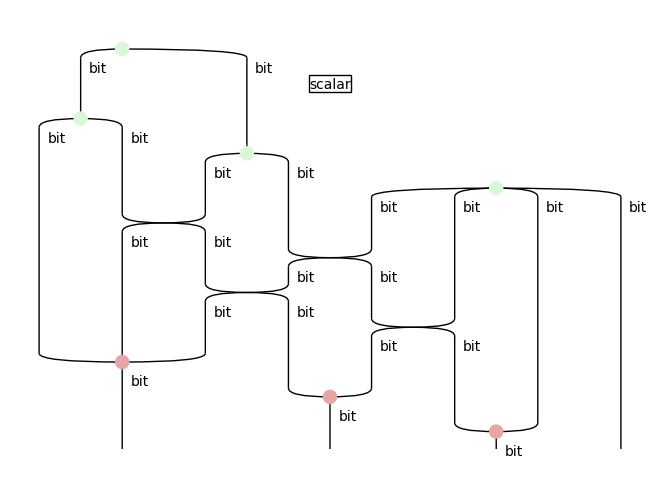

In [41]:
encoder = (
        zx.Z(1, 2) @ zx.Z(1, 2) @ zx.Z(0, 4)
        >> optyx.Diagram.permutation([0,2,4,1,5,3,6,7], optyx.bit ** 8)
        >> zx.X(3,1) @ zx.X(2,1) @ zx.X(2,1) @ zx.Id(1)
)

logical_bell = zx.Z(0,2) @ zx.Scalar(2) >> encoder
logical_bell_measurement = logical_bell.dagger()

Logical_bell = Channel('|00> + |11>', logical_bell)
Logical_bell_measurement = Channel('<00| + <11|', logical_bell_measurement)

logical_00 = zx.Z(0,4) @ zx.Scalar(1/np.sqrt(2))
logical_00_measurement = logical_00.dagger()

Logical_00 = Channel('|00>', logical_00)
Logical_00_measurement = Channel('<00|', logical_00_measurement)

logical_bell.draw()

### Defining the circuit with probabilistic bit-flips on data qubits

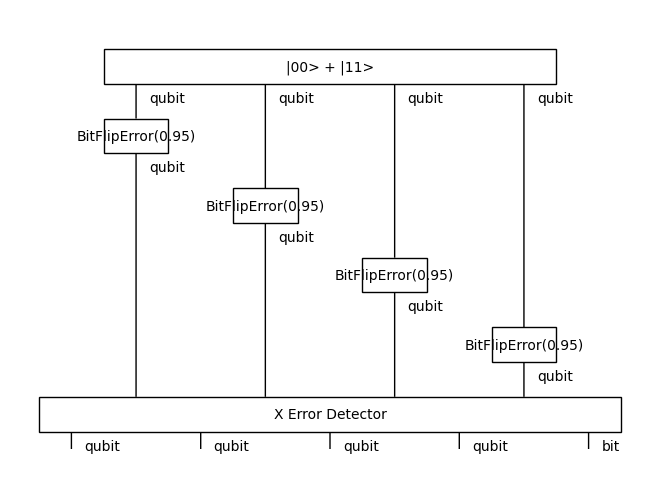

In [42]:
p_error = 0.95
Imperfect_circuit = Logical_bell >> BitFlipError(p_error) ** 4 >> X_detector

Imperfect_circuit.draw()

In [43]:
(Discard(qubit ** 4) @ Bit_0).dom

optyx.channel.Ty(optyx.channel.Ob('qubit'), optyx.channel.Ob('qubit'), optyx.channel.Ob('qubit'), optyx.channel.Ob('qubit'), optyx.channel.Ob('bit'))

### Computing the fidelity after one round of X error detection

In [44]:
P_s_eq_0 = Imperfect_circuit >> Discard(qubit ** 4) @ Bit_0
p_s_eq_0 = P_s_eq_0.double().to_tensor().eval().array

P_00_and_s_eq_0 = Imperfect_circuit >> Logical_bell_measurement @ Bit_0
p_00_and_s_eq_0 = P_00_and_s_eq_0.double().to_tensor().eval().array

fidelity = p_00_and_s_eq_0 / p_s_eq_0
print("Calculated fidelity:", np.sqrt(fidelity).real)

Calculated fidelity: 0.9945355195789248


## Calculating the fidelity for the distributed [4,2,2] code with an imperfect Bell state on the network

### Defining the network Bell state from its density matrix

![Density Matrix](densityMatrix.png)

The state has a fidelity of 96.89(8)% to the |Ψ+⟩ Bell state.
https://www.nature.com/articles/s41586-024-08404-x

In [45]:
bell_density_re = np.array([
    [0.012, 0.014, 0.014, 0.000],
    [0.014, 0.508, 0.475, 0.008],
    [0.014, 0.475, 0.479, 0.009],
    [0.000, 0.008, 0.009, 0.000]
])
bell_density_im = np.exp(1j * np.pi * np.array([
    [0.000, -1.850, -1.825, -0.985],
    [1.850, 0.000, -0.002, -0.902],
    [1.825, 0.002, 0.000, -0.931],
    [0.985, 0.902, 0.931, 0.000]
]))

bell_density = np.multiply(bell_density_re, bell_density_im)
np.set_printoptions(precision=3)
print(bell_density)

[[ 0.012+0.j     0.012+0.006j  0.012+0.007j  0.   -0.j   ]
 [ 0.012-0.006j  0.508+0.j     0.475-0.003j -0.008-0.002j]
 [ 0.012-0.007j  0.475+0.003j  0.479+0.j    -0.009-0.002j]
 [-0.   +0.j    -0.008+0.002j -0.009+0.002j  0.   +0.j   ]]


In [46]:
from discopy import tensor

bell = optyx.Box(name="Bell", dom=optyx.bit ** 2, cod=optyx.bit ** 2, truncation=bell_density)
bell = optyx.Spider(0, 2, typ=optyx.bit) >> optyx.Id(optyx.bit) @ optyx.Spider(0, 2, typ=optyx.bit) @ optyx.Id(optyx.bit) >> optyx.Diagram.permutation([0,1,3,2], optyx.bit**4) >> optyx.Id(optyx.bit ** 2) @ bell >> optyx.Diagram.permutation([0,2,1,3], optyx.bit**4)

Noisy_bell = DensityMatrix('Physical Bell', bell @ optyx.Scalar(1/0.999), dom=Ty(), cod=qubit ** 2)
Noisy_bell_HH = DensityMatrix('Physical Bell', bell @ optyx.Scalar(1/0.999), dom=Ty(), cod=qubit ** 2) >> H @ H

#### Verifying fidelity

In [47]:
Perfect_Bell = Channel("Perfect Bell", optyx.Spider(0,2,typ=optyx.bit) @ optyx.Scalar(1 / np.sqrt(2)))
Perfect_Bell_Effect = Channel("Perfect Bell Effect", optyx.Spider(2,0,typ=optyx.bit) @ optyx.Scalar(1 / np.sqrt(2)))

print("Calculated fidelity:", (Noisy_bell >> Circuit.id(qubit) @ X >> Perfect_Bell_Effect).double().to_tensor().eval().array.real)
print("Calculated fidelity (HH):", (Noisy_bell_HH >> Circuit.id(qubit) @ Z >> Perfect_Bell_Effect).double().to_tensor().eval().array.real)

Calculated fidelity: 0.9694600839906553
Calculated fidelity (HH): 0.9694600839906553


### Defining the circuit for the distributed physical implementation

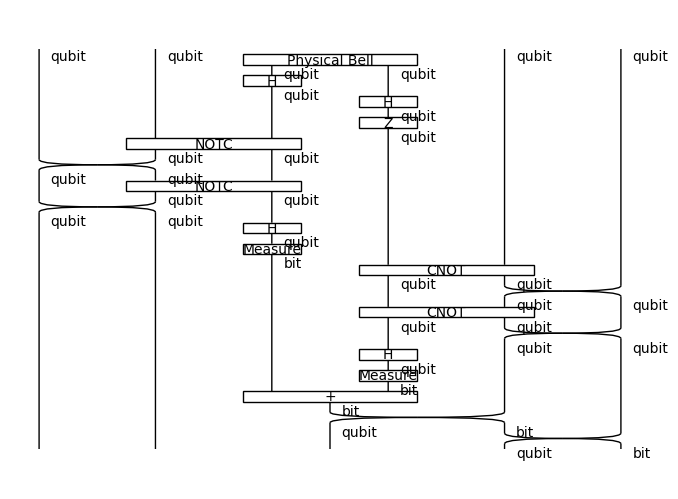

In [48]:

Left_module = Circuit.id(qubit) @ NOTC >> Circuit.permutation([1, 0, 2], qubit ** 3) >> Circuit.id(qubit) @ NOTC >> Circuit.permutation([1, 0, 2], qubit ** 3) >> Circuit.id(qubit ** 2) @ (H >> Measure(qubit))

Right_module = CNOT @ Circuit.id(qubit) >> Circuit.id(qubit) @ Circuit.swap(qubit, qubit) >> CNOT @ Circuit.id(qubit) >> Circuit.id(qubit) @ Circuit.swap(qubit, qubit) >> (H >> Measure(qubit)) @ Circuit.id(qubit ** 2)

Left_Z_module = Left_module
Right_Z_module = Right_module
Left_X_module = H ** 2 @ Circuit.id(qubit) >> Left_module >> H ** 2 @ Circuit.id(bit)
Right_X_module = Circuit.id(qubit) @ H ** 2 >> Right_module >> Circuit.id(bit) @ H ** 2

ClassicalPlus = Channel("+", zx.X(2,1) @ zx.Scalar(np.sqrt(2)), dom=bit**2, cod=bit)

Physical_Z_detector = Circuit.id(qubit ** 2) @ (Noisy_bell_HH >> Circuit.id(qubit) @ Z) @ Circuit.id(qubit ** 2) >> Left_Z_module @ Right_Z_module >> Circuit.id(qubit ** 2) @ ClassicalPlus @ Circuit.id(qubit ** 2) >> Circuit.permutation([0,1,3,4,2], qubit ** 2 @ bit @ qubit ** 2)

Physical_X_detector = Circuit.id(qubit ** 2) @ (Noisy_bell_HH >> Circuit.id(qubit) @ Z) @ Circuit.id(qubit ** 2) >> Left_X_module @ Right_X_module >> Circuit.id(qubit ** 2) @ ClassicalPlus @ Circuit.id(qubit ** 2) >> Circuit.permutation([0,1,3,4,2], qubit ** 2 @ bit @ qubit ** 2)

Physical_Z_detector.draw()

In [49]:
def is_causal(diag, verbose=False, rtol=1e-8):
    discard = Discard(diag.dom).double().to_tensor().eval().array
    unitary_then_discard = (diag >> Discard(diag.cod)).double().to_tensor().eval().array
    if verbose:
        print(discard, unitary_then_discard)
    return np.allclose(discard, unitary_then_discard, rtol)

d = Noisy_bell

is_causal(d, verbose=True)

1 (1+0j)


True

### Fault-tolerant state preparation

In [50]:
Physical_Logical_00 = Ket_0 ** 4 >> Physical_Z_detector >> Circuit.id(qubit ** 4) @ Bit_0


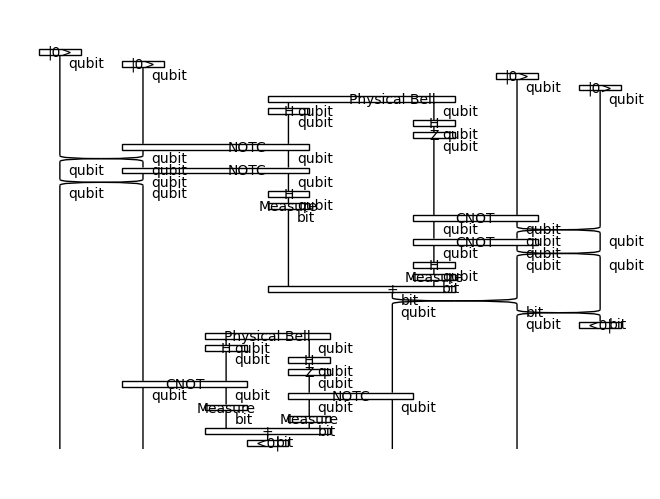

(0.9871372589170972-1.6223580999672417e-18j)
(0.9694600839906556-1.0250253473684985e-18j)


In [51]:
Extra_parity_check = Circuit.id(qubit) @ (
    Circuit.id(qubit) @ (Noisy_bell_HH >> Circuit.id(qubit) @ Z) @ Circuit.id(qubit)
    >> CNOT @ NOTC
    >> Circuit.id(qubit) @ (Measure(qubit) @ Measure(qubit) >> ClassicalPlus >> Bit_0) @ Circuit.id(qubit)
) @ Circuit.id(qubit)

Physical_FT_Logical_00 = Ket_0 ** 4 >> Physical_Z_detector >> Circuit.id(qubit ** 4) @ Bit_0 >> Extra_parity_check
Physical_FT_Logical_00.draw()

nominator = (Physical_FT_Logical_00 >> Logical_00_measurement).double().to_tensor().eval().array
denominator = (Physical_FT_Logical_00 >> Discard(qubit ** 4)).double().to_tensor().eval().array
fidelity = nominator / denominator
print(fidelity)

nominator = (Physical_Logical_00 >> Logical_00_measurement).double().to_tensor().eval().array
denominator = (Physical_Logical_00 >> Discard(qubit ** 4)).double().to_tensor().eval().array
fidelity = nominator / denominator
print(fidelity)

### Calculating fidelity for Z error detection

In [52]:
0.97**2

0.9409

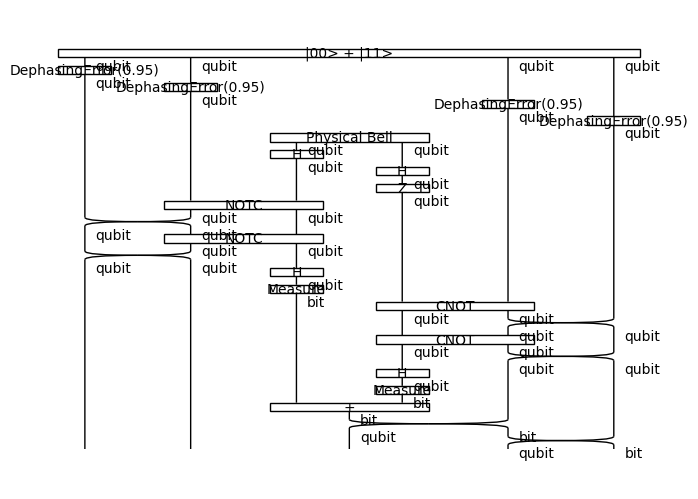

In [53]:
Imperfect_circuit = Logical_bell >> DephasingError(p_error) ** 4 >> Physical_Z_detector
Imperfect_circuit.draw()

In [54]:
P_s_eq_0 = Imperfect_circuit >> Discard(qubit ** 4) @ Bit_0
p_s_eq_0 = P_s_eq_0.double().to_tensor().eval().array

P_00_and_s_eq_0 = Imperfect_circuit >> Logical_bell_measurement @ Bit_0
p_00_and_s_eq_0 = P_00_and_s_eq_0.double().to_tensor().eval().array

fidelity = p_00_and_s_eq_0 / p_s_eq_0
print("Calculated fidelity for Z error detection:", np.sqrt(fidelity.real))

Calculated fidelity for Z error detection: 0.9839247650839148


### Calculating fidelity for a whole round of Z and X error detection

In [55]:
Imperfect_circuit = Logical_bell >> DephasingError(p_error) ** 4 >> Physical_Z_detector >> BitFlipError(p_error) ** 4 @ Circuit.id(bit) >> Physical_X_detector @ Circuit.id(bit)

P_s_eq_0 = Imperfect_circuit >> Discard(qubit ** 4) @ Bit_0 @ Bit_0
p_s_eq_0 = P_s_eq_0.double().to_tensor().eval().array

P_00_and_s_eq_0 = Imperfect_circuit >> Logical_bell_measurement @ Bit_0 @ Bit_0
p_00_and_s_eq_0 = P_00_and_s_eq_0.double().to_tensor().eval().array

fidelity = p_00_and_s_eq_0 / p_s_eq_0
print("Calculated fidelity a whole round of error detection:", np.sqrt(fidelity.real))

Calculated fidelity a whole round of error detection: 0.9683118212658504


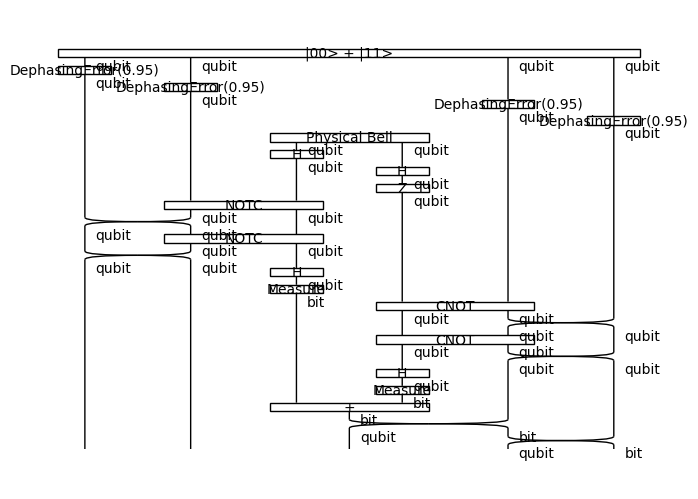

In [56]:
Imperfect_circuit = Logical_bell >> DephasingError(p_error) ** 4 >> Physical_Z_detector
Imperfect_circuit.draw()

## Two-qubit bit-flip with a two-qubit phase-flip repetition code

In [57]:
(Ket_0 ** 4 >> Physical_Z_detector >> Discard(qubit ** 4 @ bit)).double().to_tensor().eval().array

array(1.+1.626e-19j)

In [58]:
(Ket_0 ** 4 >> Physical_Z_detector >> Logical_00_measurement @ Bit_0).double().to_tensor().eval().array

array(0.485-4.337e-19j)

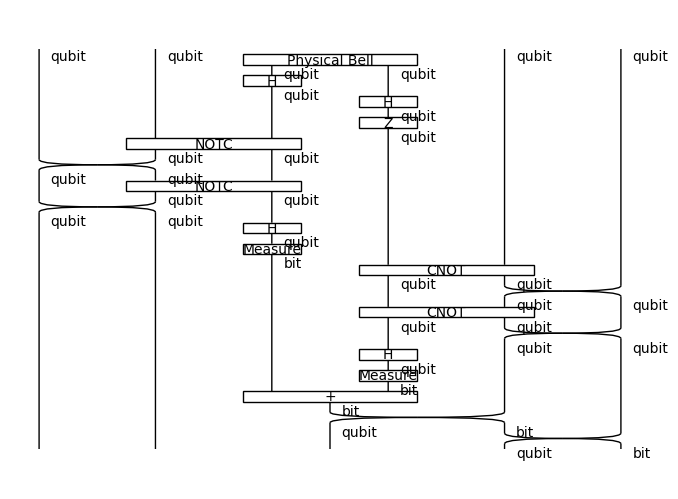

In [59]:
Physical_Z_detector.draw()

In [60]:
(Ket_0 @ Ket_0 @ Ket_0 >> Right_Z_module >> Discard(bit @ qubit ** 2)).double().to_tensor().eval().array

array(1.+0.j)